In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
words = open('names.txt', 'r').read().splitlines()

In [7]:
len(words)

32033

In [8]:
# build the vocab 
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)
vocab_size = len(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
block_size = 3 #context_length

In [57]:
def build_dataset(words): #aptly named
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size #starts as block_size #'.'s. (Since itos[0] is . and we use the integer representation of the character)
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [58]:
dim_embed = 10 #dimensions of embedding vectors
n_hidden = 200 # number of neurons in hidden layer
total_embed = dim_embed * block_size #number of inputs to hidden layer (# of embedding vectors * length of each embedding vector)

C = torch.randn((vocab_size,dim_embed))
W1 = torch.randn((total_embed,n_hidden)) * W1_kai # * 0.1
# b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden,vocab_size)) * W2_kai # * 0.01 #CHECK CELL WITH plt.hist(h.view(-1),tolist(), 50) for explanation of 0.01 and 0
b2 = torch.randn(vocab_size) * 0 # See above comment


bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, b2, W2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [24]:
#calculating std dev for kaiming init
W1_kai = (5/3) / (total_embed**0.5)
W2_kai = (5/3) / (n_hidden**0.5)

In [18]:
#Calculating batch norm for hpreact
(hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
#formula: (parameter - mean activation) / activation std dev

tensor([[-0.4657,  0.5376, -0.9898, -1.6931, -0.4427, -0.8778,  0.4226, -0.0782,
         -0.3619, -0.5695, -0.7379,  1.3303, -1.7431,  0.1304, -0.5609, -0.4738,
          0.0559, -0.4704, -2.7001, -1.9737,  0.8350, -1.4532,  0.6309,  0.8313,
          0.6729,  1.9900,  0.4084,  1.0486,  0.0302, -0.2511, -1.7469,  1.3563,
          0.3656, -0.3802, -0.6595, -0.5553,  0.5440, -0.1497,  1.2714, -0.7830,
          0.0776,  0.2678,  0.8321, -0.6898,  1.2957, -0.2292, -0.4819, -1.8133,
         -0.0711,  0.0428, -0.0713, -0.6589, -0.0041,  0.6217, -1.0598,  0.7743,
         -0.5382,  0.2839, -1.0580, -1.2253, -0.9153,  2.0755,  0.4266,  0.4969,
          0.4255, -0.3665,  0.3549,  0.3862, -0.0786, -0.3476, -1.2259,  1.1981,
         -1.7364,  0.1317, -0.6758, -1.3595,  0.6529, -0.4624,  0.9021, -0.4725,
          0.0201,  0.2066,  0.2738, -0.0658,  0.6893, -1.1318,  1.0341, -1.7255,
         -2.0196,  1.3839, -0.9326, -0.0487, -1.3891, -0.0487,  0.4344,  1.8833,
          0.6110, -0.4537, -

In [62]:
max_steps = 200000
batch_size = 32
lossi = []

for _ in range(max_steps):

    #mini-batch of size 32
    ix = torch.randint(0, Xtr.shape[0], (batch_size, )) #returns the indexes of <batch_size> samples from our train set
    
    #forward pass
    emb = C[Xtr[ix]] # (batch_size, context_length, n_embedding)
    
    #Linear Layer
    hpreact = emb.view(emb.shape[0], total_embed) @ W1 #+ b1
    
    #BatchNorm Layer
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias #batch norm #the gain allows the models to learn to strech or compress the gaussian distribution
    #and bnbias allows the model to learn to offset the gaussian dist. center by any amount. This makes it so the gaussian distribution is the more dynamic
    # and isn't always just a perfect gaussian (0 mean and 1 std dev). ALso, since bngain is initialized to all 1s, and bnbias is initialized to all zeros,
    # our weights are gaussian at initialization like we want.

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd

    #Non-linearity
    h = torch.tanh(hpreact) # (32, 100), first layer
    logits = h @ W2 + b2 # (32, 27), output layer
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims= True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix]) # this is better than the three lines above
    # print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    for p in parameters:
        p.data += -0.1 * p.grad

    #track stats
    lossi.append(loss.log10().item())
    break

print(loss.item())

tensor([[-0.7530,  1.2555,  2.2170,  ...,  0.0441, -0.0531, -0.8848],
        [ 0.9218, -0.7382,  0.2839,  ..., -2.5065,  0.8397, -0.5224],
        [-0.7664,  0.0102,  1.8616,  ..., -0.5130,  1.2129, -1.0442],
        ...,
        [ 1.1787, -0.7933,  1.0677,  ...,  2.2720, -0.7450,  1.9444],
        [ 4.0824, -1.8027,  2.1916,  ...,  1.1164,  2.5413, -1.4426],
        [ 1.0189, -0.0648, -0.1052,  ..., -1.5382,  0.2308,  1.4064]],
       grad_fn=<MmBackward0>) torch.Size([32, 200])
tensor([[0.9995, 0.9988, 0.9983, 1.0005, 1.0008, 0.9989, 1.0010, 1.0002, 1.0001,
         0.9996, 0.9990, 0.9992, 0.9990, 0.9983, 0.9989, 1.0001, 0.9965, 1.0014,
         0.9996, 0.9999, 0.9998, 1.0005, 0.9996, 1.0003, 0.9965, 0.9992, 0.9991,
         0.9989, 1.0008, 1.0029, 0.9973, 0.9973, 1.0005, 1.0000, 1.0006, 1.0017,
         0.9993, 1.0036, 0.9989, 0.9981, 0.9998, 0.9998, 0.9972, 1.0006, 0.9995,
         0.9958, 1.0005, 1.0002, 0.9998, 0.9998, 0.9973, 1.0000, 0.9995, 1.0008,
         0.9985, 1.0006, 0.9

'\nNOTE ON THE BELOW GRAPH AND WHY WE MULTIPLY W2 BY 0.01 AND B2 BY 0:\n\nGRAPH:\nAs the graph shows,the majority of h\'s values (the outputs of the tanh function) are near either 1.0 or -1.0. Tanh is an activation function that \nsqueezes values between -1 and 1, and more extreme values are set closer to -1 or 1. This is an issue because the gradients calculated for the tanh\nneuron is calculated via (1-(tanh(neuron_value)**2)) so if the output of tanh is -1 or 1, then the gradient of the neuron will be zero and the neuron \nwill not learn. This neuron will be most likely "dead" and not learn anymore. This is an issue.\n\nWHY 0.01 AND 0?\nIntuitive explanation of issue: Our model can choose from 1 of 27 characters, so if it chose completely at random, we would expect it to have an\naccuracy of about 1/27 and a loss of loss_fn(1/27), but our model at initialization has a loss much greater than this even thought we\'re initializing\nvalue randomly.\n\n\n'

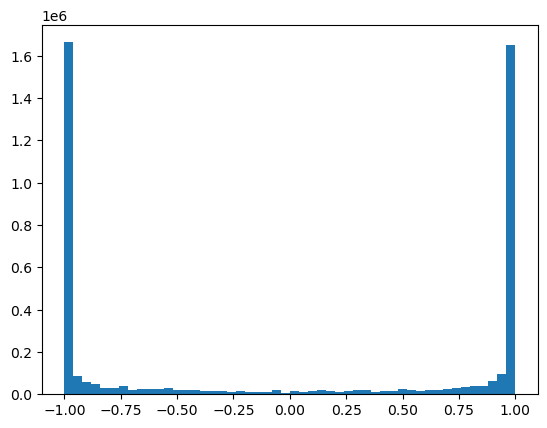

In [31]:
#DON'T RERUN
plt.hist(h.view(-1).tolist(), 50)
"""
NOTE ON THE BELOW GRAPH AND WHY WE MULTIPLY W2 BY 0.01 AND B2 BY 0:

GRAPH:
As the graph shows, the majority of h's values (the outputs of the tanh function) are near either 1.0 or -1.0. Tanh is an activation function that 
squeezes values between -1 and 1, and more extreme values are set closer to -1 or 1. This is an issue because the gradients calculated for the tanh
neuron are calculated via (1-(tanh(neuron_value)**2)) so if the output of tanh(neuron_value) is -1 or 1, then the gradient of the neuron will be zero and the neuron 
will not learn. This neuron will be most likely "dead" and not learn anymore. This is an issue. (REMEMBER: The output of the initial neuron summing
is sent through the activiation function (tanh), not each weight & bias individually) (SOLUTION (THE 0.1 AND 0.01 ON W1 AND B1): Shrink the weights
 and biases going into the neuron to get a smaller value passed into the activation function)

WHY 0.01 AND 0?
Intuitive explanation of issue: Our model can choose 1 of 27 characters, so if it chose completely at random, we would expect it to have an
accuracy of about 1/27 and a loss of loss_fn(1/27), but our model at initialization has a loss much greater than this even thought we're initializing
weight & bias values randomly.

This is due to the random fully random initialization of our weights and biases. Our weights and biases when completely random, will output extreme
probabilities for predictions that unlikely to be correct, resulting in extremely high loss. For example, the output before softmax might be big values 
like:
[-3.43, 34.43, -43.325, -12.325, 24.2] and after softmax look like:
[3.6107e-17, 9.9996e-01, 1.7038e-34, 4.9493e-21, 3.6070e-05] and if the model doesn't randomly happen to predict correctly, the loss will be huge.
So, to remedy this, we multiply the randomly initialized weights of our final layer by a small number (0.01 in our cases) to make its outputs (and therefore
inputs into softmax) much smaller and less extreme. Multiplying the bias by zero just makes sure it doesn't add back any extreme value to our summed weights.


"""

In [47]:
#Evaluation
# @torch.no_grad() #disables gradient tracking (improves efficiency)
emb = C[Xdev]
hpreact = emb.view(emb.shape[0], total_embed) @ W1
bnmean = hpreact.mean(0, keepdim=True)
bnstd = hpreact.std(0, keepdim=True)
hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias 
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1869, grad_fn=<NllLossBackward0>)

In [52]:
#Sample from model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

chettapnncoppervidhantrwanafthixzavalynnmmrdojk.
copphrandropwenvomdequavon.
chlyshautaqemphavidhimdichevidhssphraidtztistaxfthiklowalwintaellanahmichaqukoshphrvangel.
flshanmelmwhmitiqutiswavrandaldastiffhashlynnceschllttiffhizablphwestobaisleyzippshxattingtovin.
chztellipplthwishawthavidhtfthivik.
charinjanastfhapphraldiquwafthzodidge.
stopcacyproeahleofwashljnnermoktaijamimbeuliannastingttofghzwestdrwintaigourachthscacyphinzsankthixteffhafthikahlandalyndalasifshawtjinicquspphrottophinshwangelder.
collhoztellezzimbrickinleeghastacoppwinffshaustreagrompnimbreyshawtwoxzt.
jouquezzakashvikamryshljxelziger.
tzrymtieglyndelleightlxyn.
shawthewkujshothleylynton.
grintayvendra.
chraidhnkarrhingtonpelvinangeldyn.
chphrroshphavhendyshncoppurnowaidsh.
lucuschifbairick.
stophddum.
tretzaevalvyn.
cheysh.
chrgin.
chzntadlolwelzadimchperwaysynceafshohxstaellestopglpgowdum.


In [34]:
torch.softmax(torch.tensor([-3.43, 34.43, -43.325, -12.325, 24.2]), dim=0)

tensor([3.6107e-17, 9.9996e-01, 1.7038e-34, 4.9493e-21, 3.6070e-05])

In [ ]:
"""
CHECK CELL WITH plt.hist(h.view(-1),tolist(), 50) for explanation of why we muultiply W1, b1, W2, and b2 by anything in general then come here
NOTE ON KAIMING INITIALIZATION:
(Pytorch has a function for this and a good explanation at: https://pytorch.org/docs/stable/nn.init.html)

Kaiming initialization initializes weights and biases in a Gaussian (normal) distribution, with a special standard deviation. torch.randn() produces 
random initial values in a gaussian distribution, and to get the special standard deviation, we multiply the values by the desired standard deviation.
The equation for the standard deviation is (gain) / sqrt(fan_in). 
gain: specific to the activation function. check the pytorch docs above for which one to use.
fan_in: The number of input elements to the neuron

WE DO ALL OF THIS BECAUSE WE WANT OUR INPUTS TO OUR ACTIVATION FUNCTION TO BE ROUGHLY GAUSSIAN TO MAXIMIZE LEARNING. THIS IS WHY BATCH NORMA WAS CREATE. 
BATCH NORM LITERALLY NORMALIZES THE OUTPUTS OF EACH TO MAKE THEM ROUGHLY GAUSSIAN LIKE WE WANT THEM TO BE.

BECAUSE WE TAKE THE MEAN OF THE PARAMETER VALUES AND SUBSTRACT THE MEAN FROM EACH PARAMETER, THE BIAS HAS NO EFFECT. 
EX: our parameters before the bias are [4.0, 5.0, 6.0] and the output of (hpreact - bnmean) is [-1.0, 0, 1.0]. With a bias of 1, the parameters are:
[5.0, 6.0, 7.0] and the output of (hpreat - bnmean) is still [-1.0, 0, 1.0] so the bias doesn't matter anymore.
"""

## Pytorch Implementation

In [85]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d: #Check pyotrch BatchNorm1d for full explanation and docs

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum #Used for tracking running stats
        self.training = True
        #trainable parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (training with running momentum)
        #buffers are not part of backprop and are not parameters
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var #variance is std_dev**2

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_meaen = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    #make last layer less confident
    layers[-1].gamma *= 0.1
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [87]:
max_steps = 200000
batch_size= 32
lossi = []
ud = []
for i in range(max_steps):

    #constuct mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad() #for debugging
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    if i > 1000:
        break

### Summary

# Initializing weights and biases
We initialize our weights to be in a Gaussian distribution multiplied by some scaling factor calculated by (gain)/sqrt(fan_in) and the gain depends on the nonlinearity we're using. In the case on tanh, it's 5/3. This scales the initialized weights down to avoid high confidence guesses that will rarely be right which means extremely high initial loss. This saves us form that hockey-stick looking loss graph and gets rid of the initial ridiculously high loss. 
We initialize our biases to roughly zero simply because we don't want it messing up the good work we did with our weights' initialization.

# Dying Neruons
Neurons "die" when their gradient is zero. An example of when this would happen is if you have a tanh neuron, and it gets passes a very high value and the output of the tanh is 1. When tanh(x) is 1, the derivative of tanh(x) is 0. This is an issue because of the chain rule structure of gradient descent. If one gradient in a chain rule is zero, then all further gradients will be zero. For example:
The calculation for a tanh neuron gradient with respect to our neuron data x looks like dL/dx = dtanh(x)/dx * dL/dtanh(x), so if dtanh(x)/dx = 0, then the gradient will equal zero. Once the gradient is zero, none of the connections feeding into it will learn or change, so no matter the input data, the input to the neuron will always be the same and the gradient will always be zero.

# Batch Norm
Batch norm works because it forces our our input to our activiation function to be gaussian, avoiding dying neurons and extreme activations. It does so by calculating the batch mean and variance (std**2) and then normalizing the neuron's output value for each example in the batch. Batch norm has a learnable weight (gamma) and bias (beta). Gamma is a scaling term that is mutliplied by each normalized value. This makes it so the guassian distribution might be more spread out, or more compressed. The bias (beta) is added to the product of gamma and the normalized value and makes it so the guassian distirbution might not be centered at zero like normal, but at beta.
Example: If we had a batch size of 10, each example in the 10 would be fed into the neuron and the neuron would would do it's normal sum(xW) + b and then before passing this out to the activiation function to get the final output of the neuron, each of the 10 output values would be normalized relative to one another by taking the mean, and then doing: (x - xmean) / sqrt(xvar + eps) where eps stands for epsilon and is a very small value which is there to protect against divide by zero errror. These normalized values are then passed to the activiation function and this neuron's work is done for this forward pass. Als0, bias is irrelevant since we take the average and then subtract the average from each example and the out put of this (x - xmean) is the same with or without a bias.

# Embedding vectors
Embedding vectors are vectors of learnable parameters that give the model "room" to learn representations of each token in our vocabulary. For example, our embedding vectors are of size 10, so the model learns 10 values that best "represent" each token. This is how the model learns to "understand" each token.

layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.25%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.84%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 11 (      Tanh): mean -0.01, std 0.65, saturated: 2.38%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 2.12%


Text(0.5, 1.0, 'activation distribution')

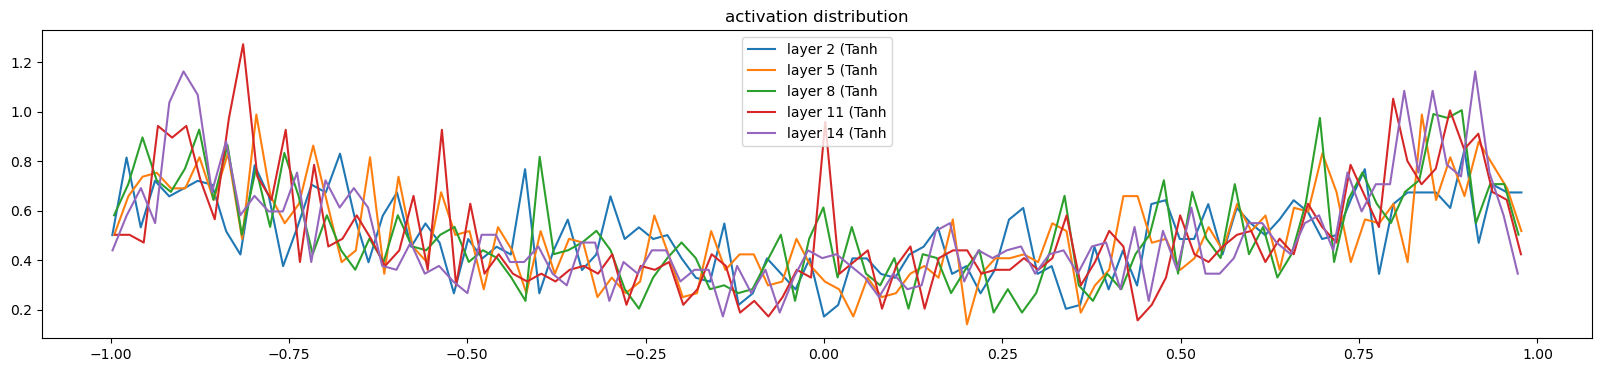

In [88]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

weight   (27, 10) | mean +0.000000 | std 8.619601e-03 | grad:data ratio 8.117311e-03
weight  (30, 100) | mean +0.000122 | std 9.024246e-03 | grad:data ratio 2.919861e-02
weight (100, 100) | mean +0.000034 | std 7.230841e-03 | grad:data ratio 4.340339e-02
weight (100, 100) | mean +0.000042 | std 6.199502e-03 | grad:data ratio 3.732989e-02
weight (100, 100) | mean +0.000059 | std 5.567998e-03 | grad:data ratio 3.338879e-02
weight (100, 100) | mean -0.000053 | std 4.920553e-03 | grad:data ratio 2.961222e-02
weight  (100, 27) | mean +0.000043 | std 8.959729e-03 | grad:data ratio 5.262299e-02


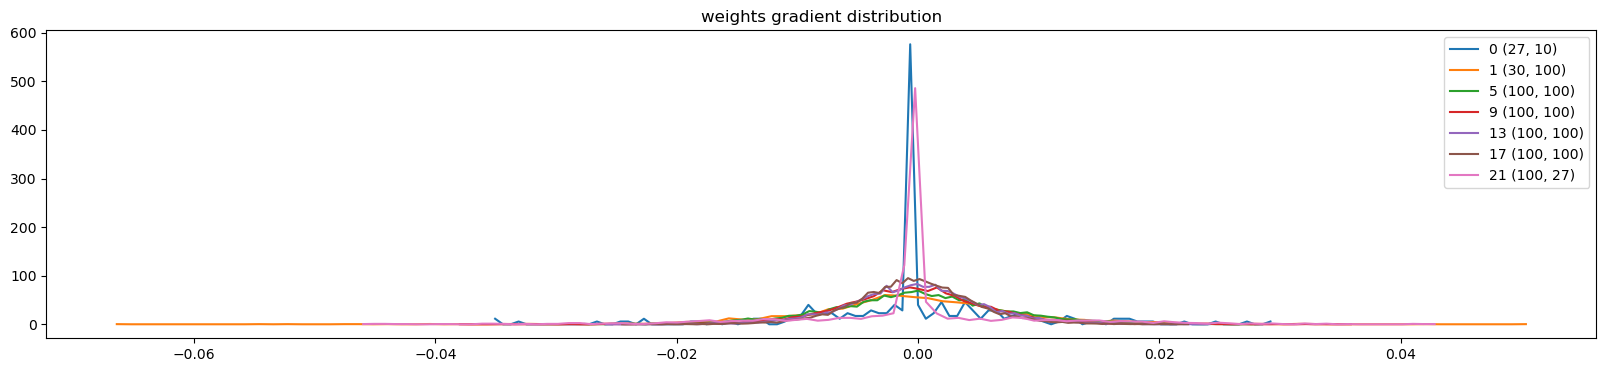

In [89]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

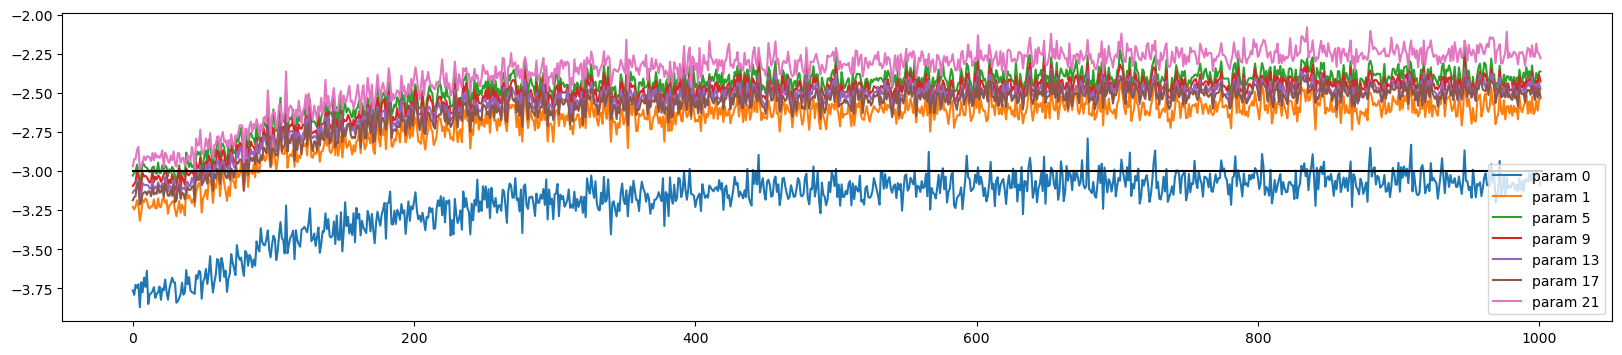

In [90]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);